In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('heart.csv')
df.head(5)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [4]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## EDA

In [5]:
# Summary statistics
df.describe()

age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000     0.000000    71.000000     0.000000     0.000000   
25%       0.000000     0.000000   132.000000     0.000000     0.000000   
50%       0.000000     1.000000   152.000000     0.000000     0.800000   
75%       0.000000     1.000000   166.000000     1.000000     1.800000   
max       1.000000     2.000000   202.000000     1.000000     6.200000   

             slope           ca         thal       target  
count  1025.000000  1025.000000  1025.000000  1025.000000  
mean      1.385366     0.754146     2.323902     0.513171  
std       0.617755     1.030798     0.620660     0.500070  
min       0.000000     0.000000     0.000000     0.000000  
25%       1.000000     0.000000     2.000000     0.000000  
50%       1.000000     0.000000     2.000000     1.000000  
75%       2.000000     1.000000     3.000000     1.000000  
max       2.000000     4.000000     3.000000     1.000000

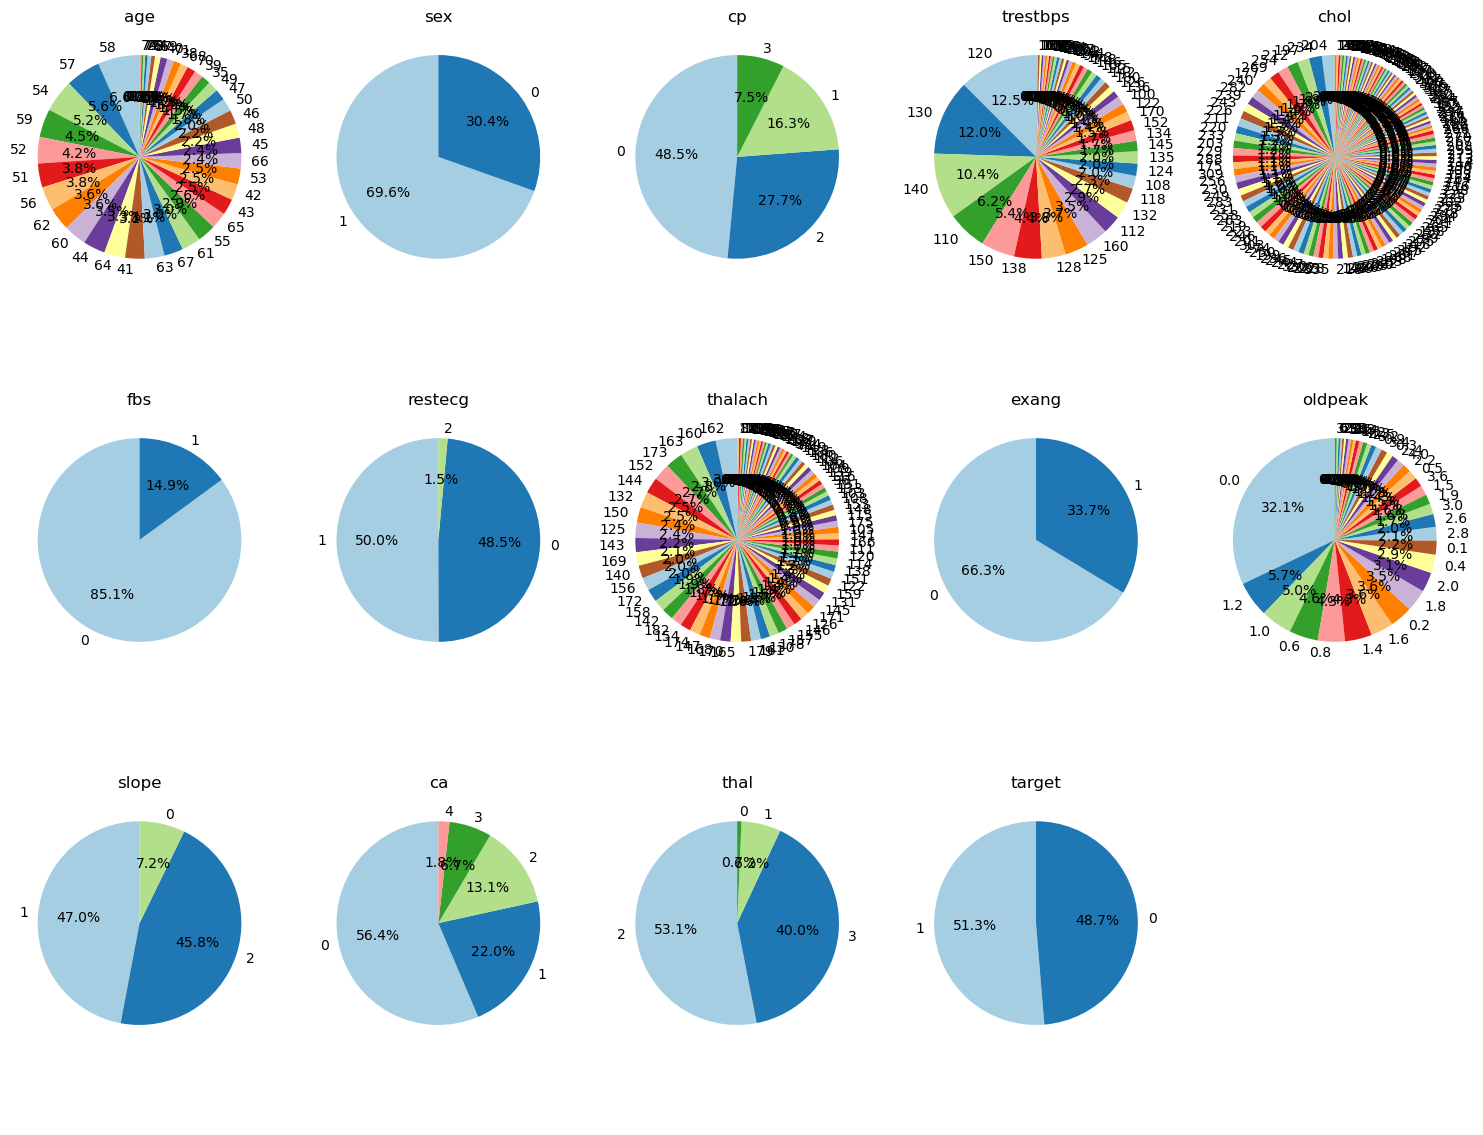

In [6]:
# Function to plot pie charts for all columns in the dataset
def plot_pie_charts(dataframe, num_cols=5):
    cols = dataframe.columns
    total_plots = len(cols)
    rows = (total_plots + num_cols - 1) // num_cols  # Calculate required rows

    fig, axes = plt.subplots(rows, num_cols, figsize=(15, rows * 4))
    axes = axes.flatten()  # Flatten in case of multiple rows

    # Plot pie charts
    for idx, col in enumerate(cols):
        values = dataframe[col].value_counts()
        axes[idx].pie(values, labels=values.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
        axes[idx].set_title(col)

    # Hide unused subplots
    for ax in axes[total_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot pie charts for all columns in the dataset
plot_pie_charts(df)


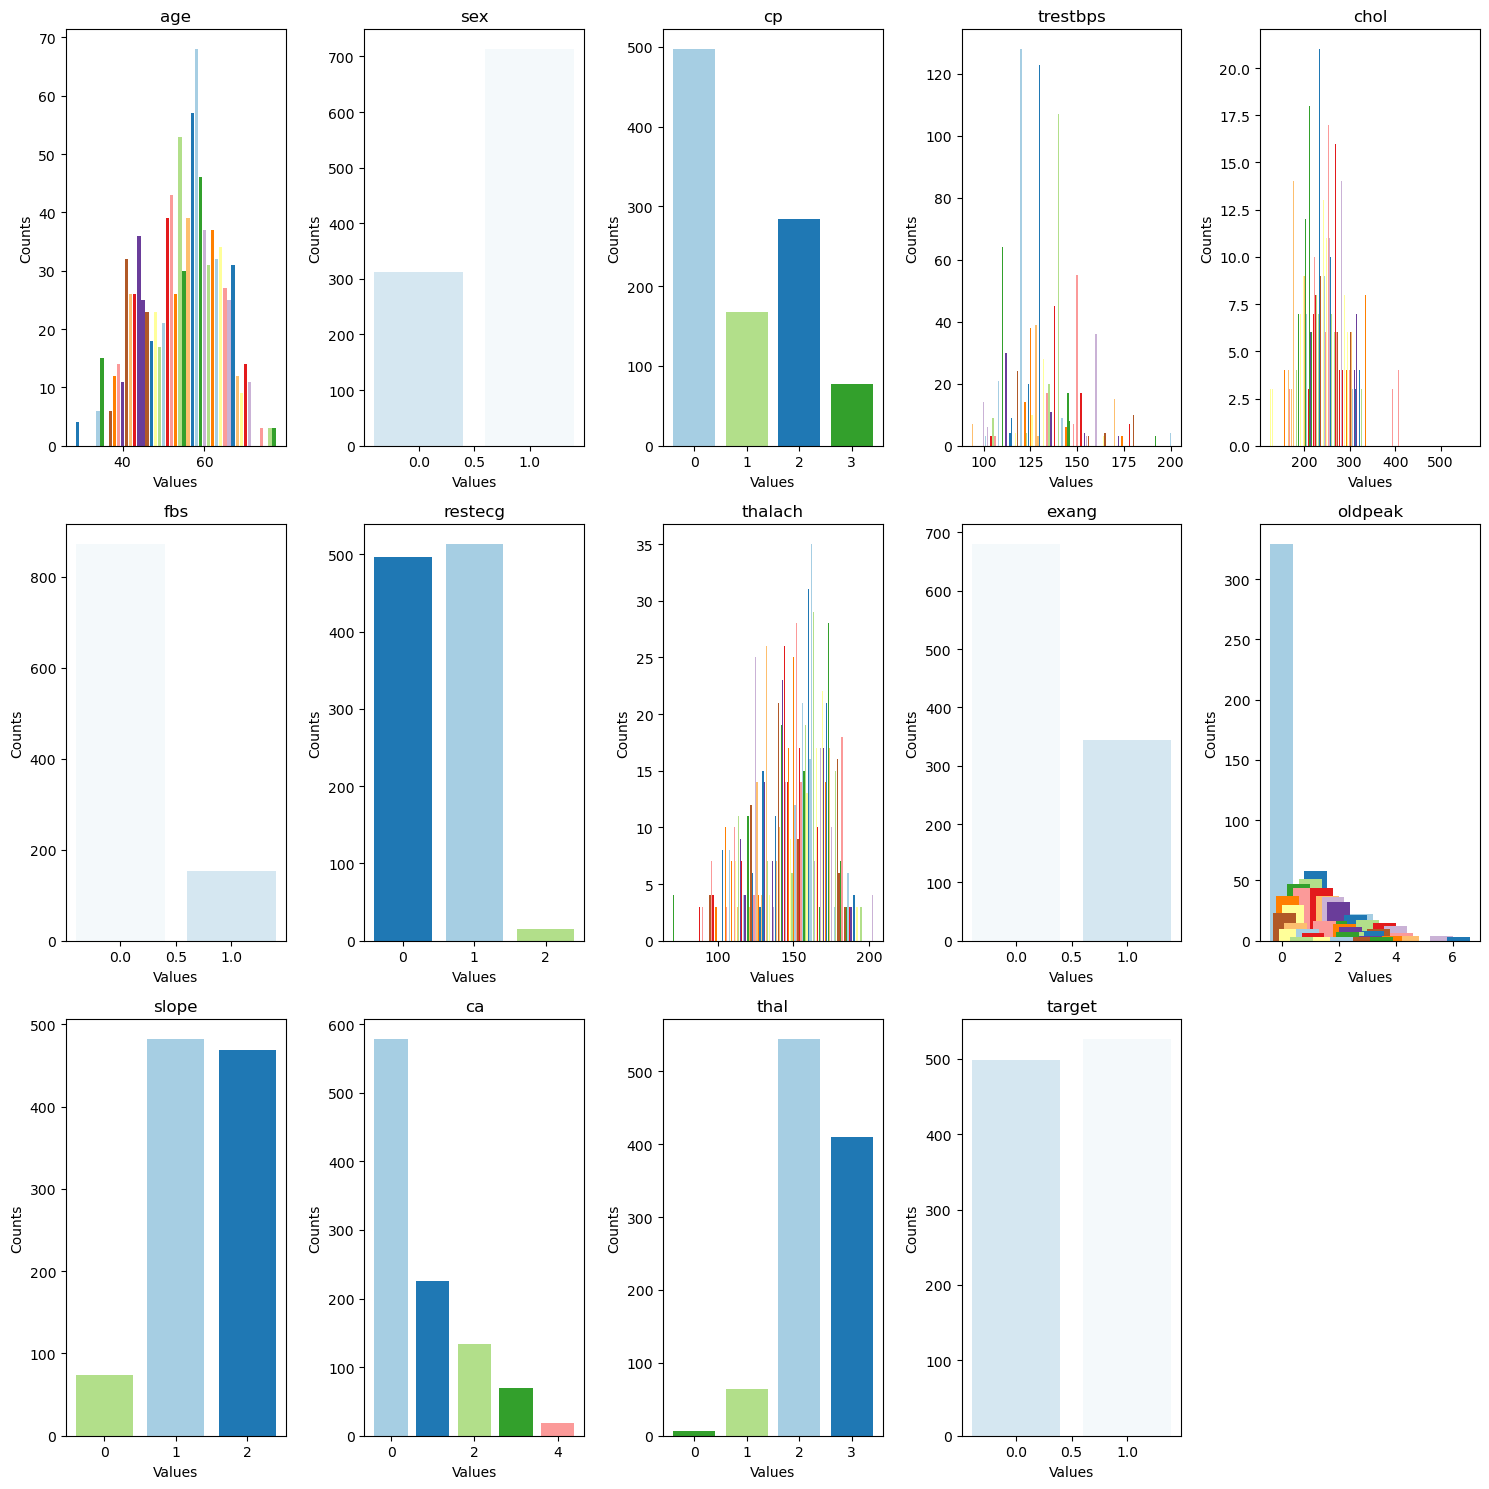

In [7]:
# Function to plot bar charts for all columns in the dataset
def plot_bar_charts(dataframe, num_cols=5):
    cols = dataframe.columns
    total_plots = len(cols)
    rows = (total_plots + num_cols - 1) // num_cols  # Calculate required rows

    fig, axes = plt.subplots(rows, num_cols, figsize=(15, rows * 5))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for idx, col in enumerate(cols):
        values = dataframe[col].value_counts()
        axes[idx].bar(values.index, values, color=plt.cm.Paired.colors[:len(values)])
        axes[idx].set_title(col)
        axes[idx].set_xlabel('Values')
        axes[idx].set_ylabel('Counts')

    # Hide unused subplots
    for ax in axes[total_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot bar charts for all columns in the dataset
plot_bar_charts(df)


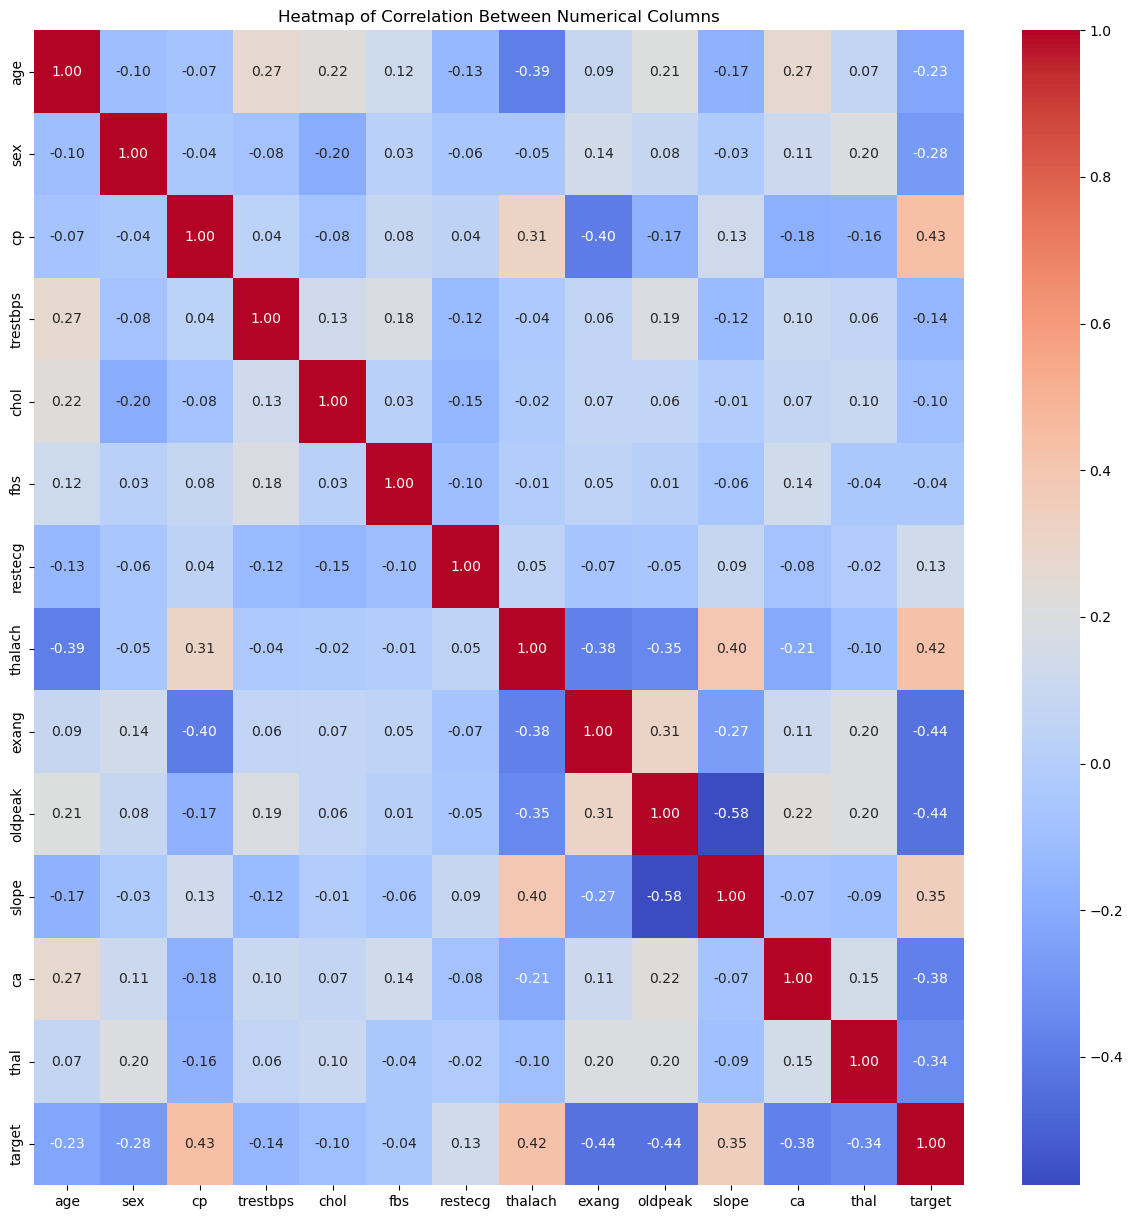

In [8]:
def plot_heatmap(dataframe):
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64'])  # Select numerical columns
    corr_matrix = numeric_cols.corr()  # Compute correlation matrix

    plt.figure(figsize=(15, 15))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Heatmap of Correlation Between Numerical Columns")
    plt.show()

# Plot heatmap for the dataset
plot_heatmap(df)


In [9]:
# Menghitung matriks korelasi
correlation_matrix = df.corr()

# Menampilkan matriks korelasi sebagai tabela
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.103240 -0.071966  0.271121  0.219823  0.121243   
sex      -0.103240  1.000000 -0.041119 -0.078974 -0.198258  0.027200   
cp       -0.071966 -0.041119  1.000000  0.038177 -0.081641  0.079294   
trestbps  0.271121 -0.078974  0.038177  1.000000  0.127977  0.181767   
chol      0.219823 -0.198258 -0.081641  0.127977  1.000000  0.026917   
fbs       0.121243  0.027200  0.079294  0.181767  0.026917  1.000000   
restecg  -0.132696 -0.055117  0.043581 -0.123794 -0.147410 -0.104051   
thalach  -0.390227 -0.049365  0.306839 -0.039264 -0.021772 -0.008866   
exang     0.088163  0.139157 -0.401513  0.061197  0.067382  0.049261   
oldpeak   0.208137  0.084687 -0.174733  0.187434  0.064880  0.010859   
slope    -0.169105 -0.026666  0.131633 -0.120445 -0.014248 -0.061902   
ca        0.271551  0.111729 -0.176206  0.104554  0.074259  0.137156   
thal      0.072297  0.198424 -0.163341  0.05

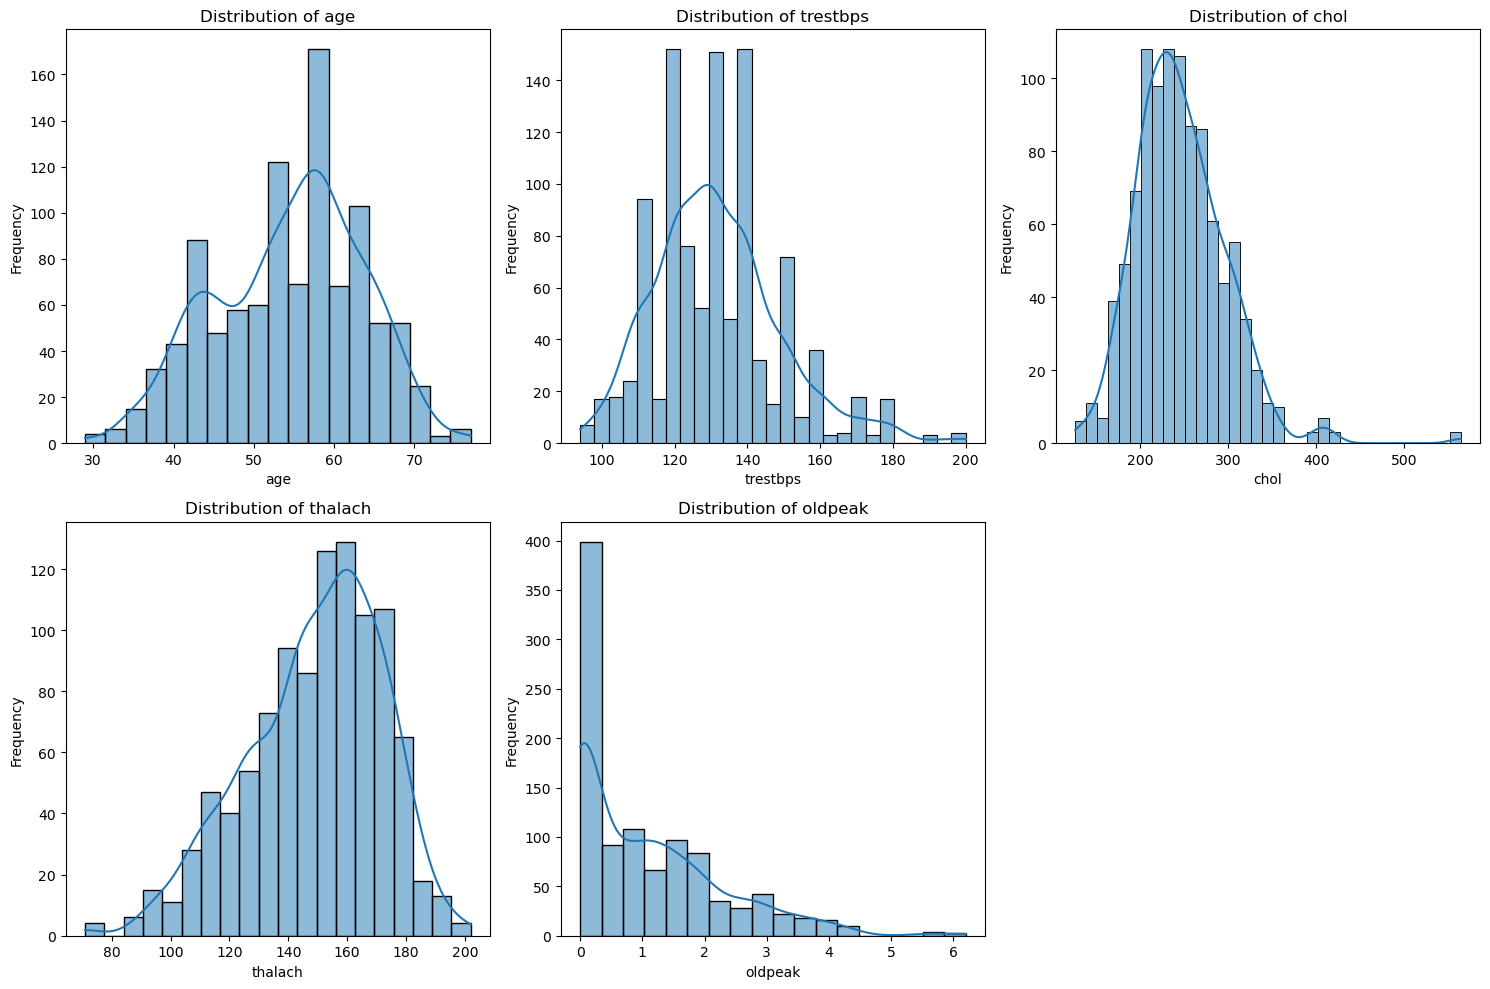

In [10]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create the histogram
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[feature], kde=True)  # Use seaborn for better visualization
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout() # Adjust spacing between subplots
plt.show()

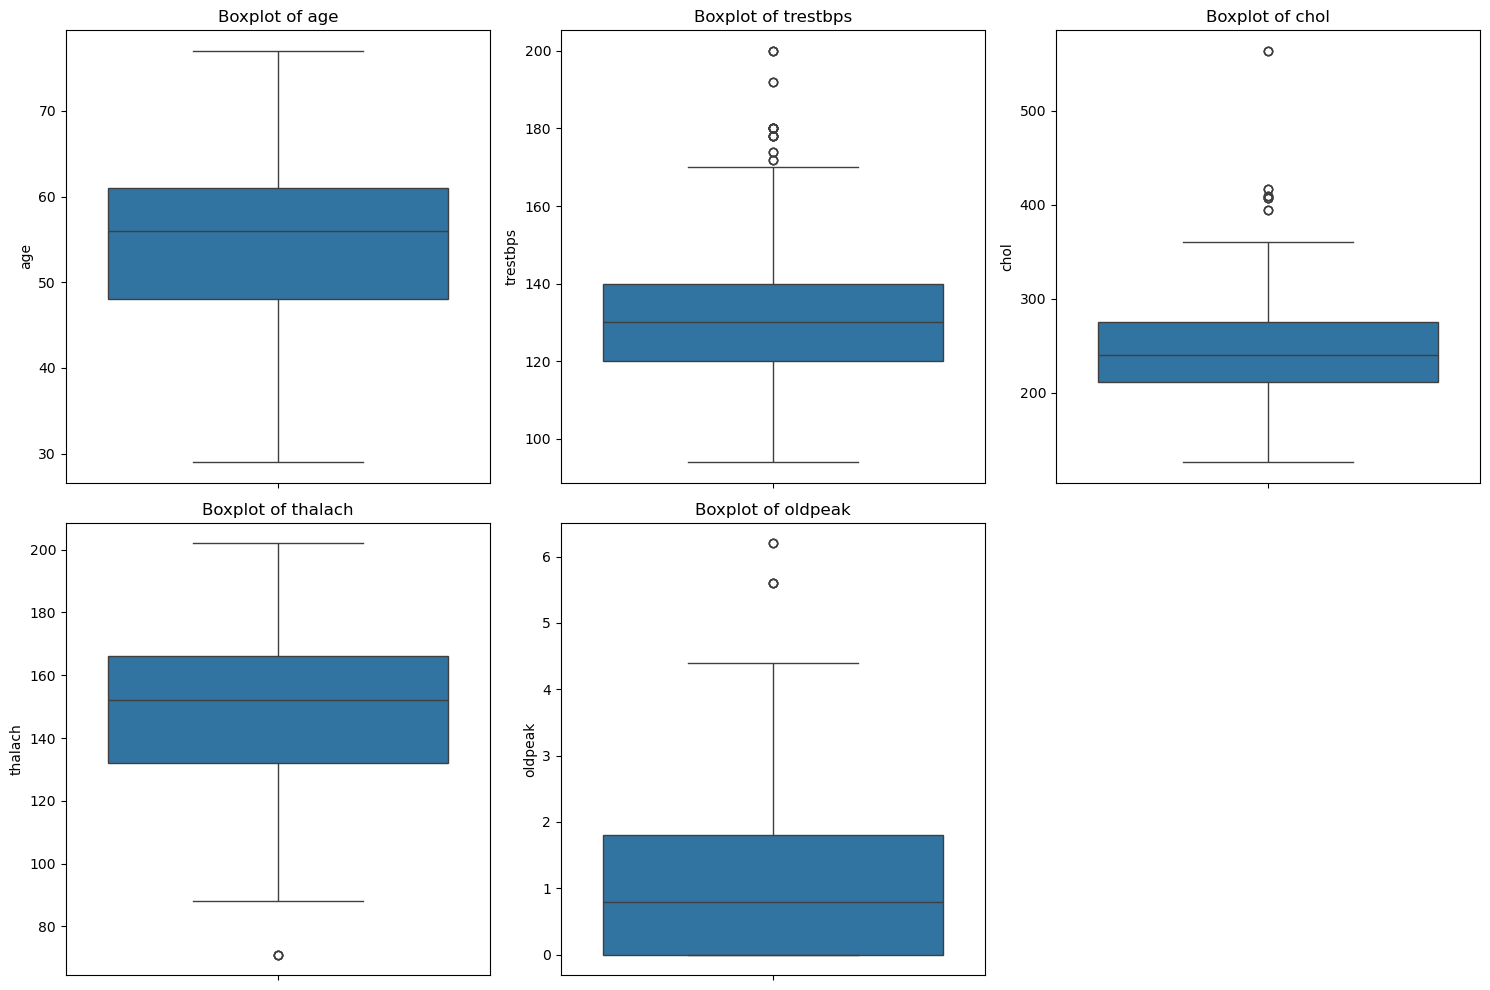

In [11]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create the boxplot
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[feature])  # Use seaborn for better visualization
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## PENGUJIAN

In [12]:
# Split features and target
X = df.drop(columns=['target']).values
y = df['target'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Create DataLoader 
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)  


In [13]:
# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation_function):
        super(MLPModel, self).__init__()
        layers = []
        current_dim = input_dim
        
        # Add hidden layers
        for hidden_neurons in hidden_layers:
            layers.append(nn.Linear(current_dim, hidden_neurons))
            if activation_function == 'relu':
                layers.append(nn.ReLU())
            elif activation_function == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_function == 'tanh':
                layers.append(nn.Tanh())
            elif activation_function == 'linear':
                pass  # No activation for linear
            elif activation_function == 'softmax':
                layers.append(nn.Softmax(dim=1))
            current_dim = hidden_neurons
        
        # Add output layer
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())  # Binary classification
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [14]:
# Hyperparameter grid
hidden_layers_options = [
    [4], [8], [16], [32], [64],    # 1 hidden layer
    [4, 4], [8, 8], [16, 16], [32, 32], [64, 64],  # 2 hidden layers
    [4, 8, 4], [8, 16, 8], [16, 32, 16], [32, 64, 32], [64, 128, 64] # 3 hidden layers
]
activation_options = ['linear', 'sigmoid', 'relu', 'softmax', 'tanh']
epoch_options = [1, 10, 25, 50, 100, 250]
learning_rate_options = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_size_options = [16, 32, 64, 128, 256, 512]

# Save configuration for progress tracking
results = []

# Function to evaluate model
def train_and_evaluate(hidden_layers, activation_function, epochs, learning_rate, batch_size):
    # Create DataLoader (using the full dataset)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss, and optimizer
    model = MLPModel(input_dim=X_tensor.shape[1], hidden_layers=hidden_layers, activation_function=activation_function)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    model.train()
    epoch_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # Calculate average loss for this epoch
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in train_loader:  # Using the entire dataset for evaluation
            predictions = model(batch_X)
            predicted = (predictions > 0.5).float()
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    accuracy = correct / total
    return accuracy, epoch_losses

# Running the grid search for hyperparameters
for hidden_layers in hidden_layers_options:
    for activation in activation_options:
        for epochs in epoch_options:
            for lr in learning_rate_options:
                for batch_size in batch_size_options:
                    # Train and evaluate the model
                    accuracy, losses = train_and_evaluate(
                        hidden_layers=hidden_layers,
                        activation_function=activation,
                        epochs=epochs,
                        learning_rate=lr,
                        batch_size=batch_size
                    )
                    
                    # Store results
                    results.append({
                        'hidden_layers': hidden_layers,
                        'activation': activation,
                        'epochs': epochs,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'accuracy': accuracy,
                        'loss': losses  
                    })
                    print("============================================")
                    print(f"HL: {hidden_layers}, Act: {activation}, Epochs: {epochs}, LR: {lr}, BS: {batch_size}, Accuracy: {accuracy:.4f}, Loss: {losses[-1]:.4f}")    
                    print("============================================")

# Save the results to a CSV file
data = pd.DataFrame(results)
data.to_csv("mlp_experiment_Deep_Learning_Heart_results.csv", mode='w', header=True, index=False)


HL: [4], Act: linear, Epochs: 1, LR: 10, BS: 16, Accuracy: 0.2263, Loss: 76.2631
HL: [4], Act: linear, Epochs: 1, LR: 10, BS: 32, Accuracy: 0.4078, Loss: 58.7680
HL: [4], Act: linear, Epochs: 1, LR: 10, BS: 64, Accuracy: 0.2351, Loss: 73.9025
HL: [4], Act: linear, Epochs: 1, LR: 10, BS: 128, Accuracy: 0.7932, Loss: 32.7669
HL: [4], Act: linear, Epochs: 1, LR: 10, BS: 256, Accuracy: 0.5463, Loss: 34.7040
HL: [4], Act: linear, Epochs: 1, LR: 10, BS: 512, Accuracy: 0.2283, Loss: 26.9742
HL: [4], Act: linear, Epochs: 1, LR: 1, BS: 16, Accuracy: 0.8371, Loss: 12.4557
HL: [4], Act: linear, Epochs: 1, LR: 1, BS: 32, Accuracy: 0.8429, Loss: 11.4605
HL: [4], Act: linear, Epochs: 1, LR: 1, BS: 64, Accuracy: 0.8468, Loss: 8.2390
HL: [4], Act: linear, Epochs: 1, LR: 1, BS: 128, Accuracy: 0.8420, Loss: 8.5588
HL: [4], Act: linear, Epochs: 1, LR: 1, BS: 256, Accuracy: 0.8507, Loss: 3.7698
HL: [4], Act: linear, Epochs: 1, LR: 1, BS: 512, Accuracy: 0.7502, Loss: 5.1634
HL: [4], Act: linear, Epochs: 1,

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load hasil eksperimen dari file CSV
data = pd.read_csv("mlp_experiment_Deep_Learning_Heart_results.csV")

# Buat folder untuk menyimpan hasil plot jika belum ada
output_folder = "mlp_experiment_Deep Learning(Heart)_plots"
os.makedirs(output_folder, exist_ok=True)

# Hyperparameter grid untuk visualisasi
hidden_layers_list = [
    str([4]), str([8]), str([16]), str([32]), str([64]),  # 1 hidden layer
    str([4, 4]), str([8, 8]), str([16, 16]), str([32, 32]), str([64, 64]),  # 2 hidden layers
    str([4, 8, 4]), str([8, 16, 8]), str([16, 32, 16]), str([32, 64, 32]),  # 3 hidden layers
]
activations_list = ['linear', 'sigmoid', 'relu', 'softmax', 'tanh']
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]

# Loop melalui kombinasi parameter
for hidden_layers in hidden_layers_list:
    for activation in activations_list:
        for lr in learning_rates:
            # Filter data untuk kombinasi parameter ini
            filtered_data = data[
                (data['hidden_layers'] == hidden_layers) & 
                (data['activation'] == activation) & 
                (data['learning_rate'] == lr)
            ]
            
            if not filtered_data.empty:
                # Plot akurasi terhadap epochs untuk setiap batch size
                batch_sizes = filtered_data['batch_size'].unique()

                plt.figure(figsize=(12, 12))
                for i, batch_size in enumerate(batch_sizes, 1):
                    plt.subplot(3, 3, i)  # Buat grid 3x3
                    batch_data = filtered_data[filtered_data['batch_size'] == batch_size]
                    plt.plot(batch_data['epochs'], batch_data['accuracy'], marker='o', label=f'Batch Size: {batch_size}')
                    plt.title(f'HL: {hidden_layers}, Act: {activation}, LR: {lr}, BS: {batch_size}')
                    plt.xlabel('Epochs')
                    plt.ylabel('Accuracy')
                    plt.legend()
                    plt.grid()

                plt.tight_layout()
                
                # Nama file berdasarkan kombinasi hyperparameter
                filename = f"HL-{hidden_layers}_Act-{activation}_LR-{lr}.png"
                filepath = os.path.join(output_folder, filename)
                
                # Simpan plot ke file
                plt.savefig(filepath, dpi=150)
                plt.close() 


In [16]:
import pandas as pd

# Load the experiment results from the CSV file
results_df = pd.read_csv("mlp_experiment_Deep_Learning_Heart_results.csv")

# Sort the results by accuracy in descending order
top_results = results_df.sort_values(by="accuracy", ascending=False).head(10)

# Display the top 10 results
top_results


hidden_layers activation  epochs  learning_rate  batch_size  accuracy  \
9590        [32, 32]       tanh      25           0.10          64       1.0   
14994   [32, 64, 32]       tanh      25           0.01          16       1.0   
9232        [32, 32]       relu     100           0.10         256       1.0   
10131       [64, 64]    sigmoid     250           0.10         128       1.0   
15606  [64, 128, 64]       relu      10           0.01          16       1.0   
14564   [32, 64, 32]       relu      25           0.01          64       1.0   
13557   [16, 32, 16]       relu     100           0.01         128       1.0   
13556   [16, 32, 16]       relu     100           0.01          64       1.0   
13555   [16, 32, 16]       relu     100           0.01          32       1.0   
13554   [16, 32, 16]       relu     100           0.01          16       1.0   

                                                    loss  
9590   [0.4598642649019466, 0.37076738126137676, 0.25...  
14994  [0.43525133293408613, 0.36517155158978243, 0.3...  
9232   [0.4337046753615141, 0.28677146836416795, 0.28...  
10131  [0.8864160312546624, 0.5955139431688521, 0.494...  
15606  [0.37813295733538743, 0.2841247306420253, 0.20...  
14564  [0.4415639764903223, 0.31688060523832545, 0.26...  
13557  [0.6540074282222323, 0.4421088877651427, 0.389...  
13556  [0.5754646641366622, 0.4582844621994916, 0.344...  
13555  [0.5176854770291935, 0.35334398236238596, 0.31...  
13554  [0.45832850921612517, 0.2988141804933548, 0.27...